# Prepare data
---------------------
No to już wszystko mam zrobione więc łatwo

In [1]:
from signalutils.signalutils import readFiles, encodedLabels, calcMfccs, export_to_pickle, unpickle
import scipy

In [2]:
signals, labelEncoder = encodedLabels(readFiles(path="../samples"))

In [3]:
signals = calcMfccs(signals, window=scipy.signal.windows.boxcar, n_fft=512, hop_length=256, win_length=512, n_mfcc=13)

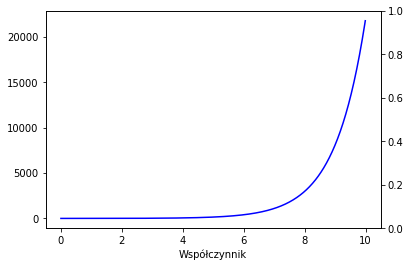

In [66]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)

s1 = np.exp(t)
ax1.plot(t, s1, 'b')
ax1.set_xlabel('Współczynnik')

ax2 = ax1.twinx()

plt.show()

In [65]:
len(signals[0]["mfccs"][0])

123

In [4]:
for signal in signals:
    signal['name'] = signal['name'].split(".")[0]

# Calc DTWs
---------------

Źródła: 
- https://www.youtube.com/watch?v=ERKDHZyZDwA&list=PLmZlBIcArwhMJoGk5zpiRlkaHUqy5dLzL&index=1
- https://www.researchgate.net/publication/260762671_Speech_recognition_using_MFCC_and_DTW
- https://stackoverflow.com/questions/48267199/comparing-mfcc-feature-vectors-with-dtw

Input: lista 112 nagrań zawierających informacje:

In [24]:
signals[0].keys()

dict_keys(['name', 'signal', 'sr', 'label', 'encodedLabel', 'mfccs', 'delta', 'delta2'])

## Approach 1 - DTW z macierzy MFCC

Jak liczymy MFCC z nagrania to zawsze dostajemy macierz o wymiarach (X,N) gdzie X - liczba okien, N - liczba współczynników. I trochę pojawia się problem, bo nie da się policzyć DTW z dwóch macierzy. Rozwiązaniem jest wykonanie innej operacji, która obliczy nam odległości pomiędzy pomiędzy wektorami (gdzie wektor to wartości współczynników w jednej chwili\oknie) i potem wynik tego obliczenia będzie już jedną macierzą, na której można od razu robić DTW.

Generalnie sprawa wygląda tak, że najpierw liczy się odległości pomiędzy wektorami z użyciem istniejących funkcji, czy to odległość euklidesowa, dot product czy inne takie i mamy już macierz na której możemy liczyć DTW.

Opcji do obliczania odległości mamy dużo https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

no generalnie prościej się nie dało, jest libka która robi dokładnie to:

https://github.com/pollen-robotics/dtw

In [5]:
from dtw import accelerated_dtw
import scipy
from tqdm.notebook import tqdm
import sys

In [4]:
#eksperymenty z crossvalidation tutaj

In [6]:
import collections


In [7]:
#najmniej nagrań ma Arek
leastRecords = collections.Counter(list(map(lambda x: x['name'][:2], signals))).most_common()[-1]
print(f"leastRecords: {leastRecords}")
print(f"speakers: {labelEncoder.classes_}")
print(f"Number of samples so that everyone has an even number of recordings: {leastRecords[1] * len(labelEncoder.classes_)}")

leastRecords: ('AM', 9)
speakers: ['AM' 'AP' 'AS' 'BG' 'CD' 'MJ' 'PP' 'TC' 'WK' 'WM' 'ZB']
Number of samples so that everyone has an even number of recordings: 99


In [8]:
#Obetnij dodatkowe nagrania tak, żeby wszyscy mieli po 9, bo Arek ma tylko 9 a żeby po równo było do kroswalidacji
evenSignals = []
for label in labelEncoder.classes_:
    speakerSignals = list(filter(lambda x: x['label']==label,signals))
    evenSignals = evenSignals + (speakerSignals[:leastRecords[1]])

99

In [5]:
#eksperymenty z crossvalidation kończą się tutaj

In [38]:
for entry_x in tqdm(signals):
    calculatedData=[]
    for entry_y in tqdm(signals):
        cost, cost_matrix, acc_cost_matrix, path = accelerated_dtw(entry_x['mfccs'].T, entry_y['mfccs'].T, scipy.spatial.distance.cosine)
        data = {
            "x": entry_x['name'],
            "y": entry_y['name'],
            "cost": cost,
            "cost_matrix": "cost_matrix",
            "acc_cost_matrix": acc_cost_matrix,
            "path":path
        }
        calculatedData.append(data)
    

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

2


In [24]:
amwk.keys()

dict_keys(['x', 'y', 'cost', 'cost_matrix', 'acc_cost_matrix', 'path'])

In [42]:
def plotCost(dtwData):
    import matplotlib.pyplot as plt
    plt.imshow(dtwData['acc_cost_matrix'].T, origin='lower', cmap='gray', interpolation='nearest')
    plt.plot(dtwData['path'][0],dtwData['path'][1], 'w')
    plt.show()
    #oszukałem trochę, bo z notatnika dtw_cost_matrix wiem, że max to 13.83032082127992
    
    print(f"DTW({dtwData['x']}, {dtwData['y']}) = {dtwData['cost']/13.83032082127992}")

In [17]:
#save data in dicts:    "AM1":{"AM1":0, "AM2:"3",...},"PP":{"AM1":20, ...}...
import os
results = dict()
for path, subdirs, files in os.walk("data"):
        for name in files:
            buffer = unpickle("data/"+name)
            for idx, element in enumerate(buffer):
                if idx == 0:
                    results[element['x']] = dict()
                results[element['x']][element['y']] = element

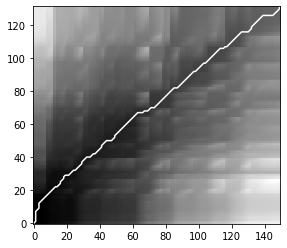

DTW(AM3, WK_01) = 0.3650530990642742


In [43]:
plotCost(results['AM3']['WK_01'])

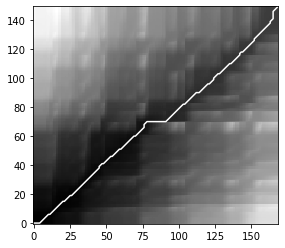

DTW(AM6, AM3) = 0.19629607432888443


In [44]:
plotCost(results['AM6']['AM3'])

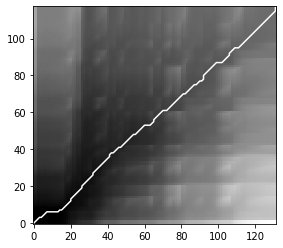

DTW(WK_01, TC2) = 0.4838481021679151


In [45]:
plotCost(results['WK_01']['TC2'])

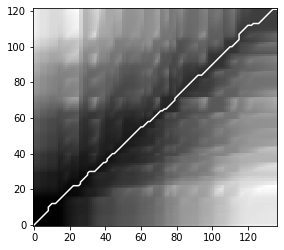

DTW(WK_03, WK_09) = 0.1492480000299585


In [46]:
plotCost(results['WK_03']['WK_09'])

# Approach 2 - Uśrednienie MFCC

Pomysł z drugim podejściem jest podobny do zadania pierwszego, gdzie liczymy jedno MFCC z całej wypowiedzi:
1. Policz mfcc z okienkami
2. Oblicz średnie wartości MFCC ze wszystkich okien
3. Oblicz DTW na tych średnich MFCC